# ベイズ線形回帰

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [2]:
# データを作成
n = 100

from scipy.stats import multivariate_normal
mean = np.array([3, 5])
Sigma = np.array([
    [1, 0.5],
    [0.5, 2],
])
X = multivariate_normal.rvs(mean=mean, cov=Sigma, size=n, random_state=0)

import statsmodels.api as sm
X = sm.add_constant(X)

# 真のパラメータ
beta = np.array([2, 3, 4])

## 均一分散の場合

In [3]:
# 均一分散の場合
e = np.random.normal(loc=0, scale=1, size=n)
y = X @ beta + e

In [4]:
# 頻度主義
import statsmodels.api as sm
ols = sm.OLS(y, X).fit(cov_type="HC1")
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     3458.
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           6.78e-91
Time:                        13:35:09   Log-Likelihood:                -128.56
No. Observations:                 100   AIC:                             263.1
Df Residuals:                      97   BIC:                             270.9
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7538      0.365      7.536      0.000       2.038       3.470
x1             2.8042      0.098     28.480      0.000       2.611       2.997
x2             3.9818      0.069     57.764      0.000       3.847       4.117
==============================================================================
Omnibus:                        1.405   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.495   Jarque-Bera (JB):                1.473
Skew:                          -0.260   Prob(JB):                        0.479
Kurtosis:                       2.712   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

↑ 切片の推定にバイアスが入っている

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


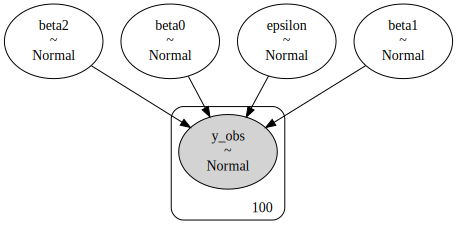

In [5]:
import pymc as pm
import arviz as az

model = pm.Model()
with model:
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    epsilon = pm.Normal("epsilon", mu=0, sigma=1)
    # 平均値 mu
    mu = beta0 + beta1 * X[:, 1] + beta2 * X[:, 2] + epsilon
    # 観測値をもつ確率変数は_obsとする
    y_obs = pm.Normal("y_obs", mu=mu, sigma=epsilon, observed=y)

# モデルをGraphvizで表示
pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, epsilon]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


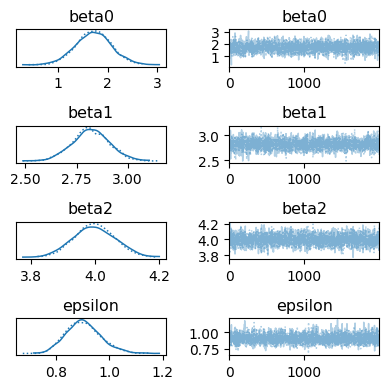

In [6]:
# ベイズ線形回帰モデルをサンプリング
with model:
    idata = pm.sample(
        chains=2,
        tune=1000, # バーンイン期間の、捨てるサンプル数
        draws=2000, # 採用するサンプル数
        random_seed=0,
    )

# 各chainsの結果を表示
az.plot_trace(idata, figsize=[4, 4])
plt.tight_layout()
plt.show()

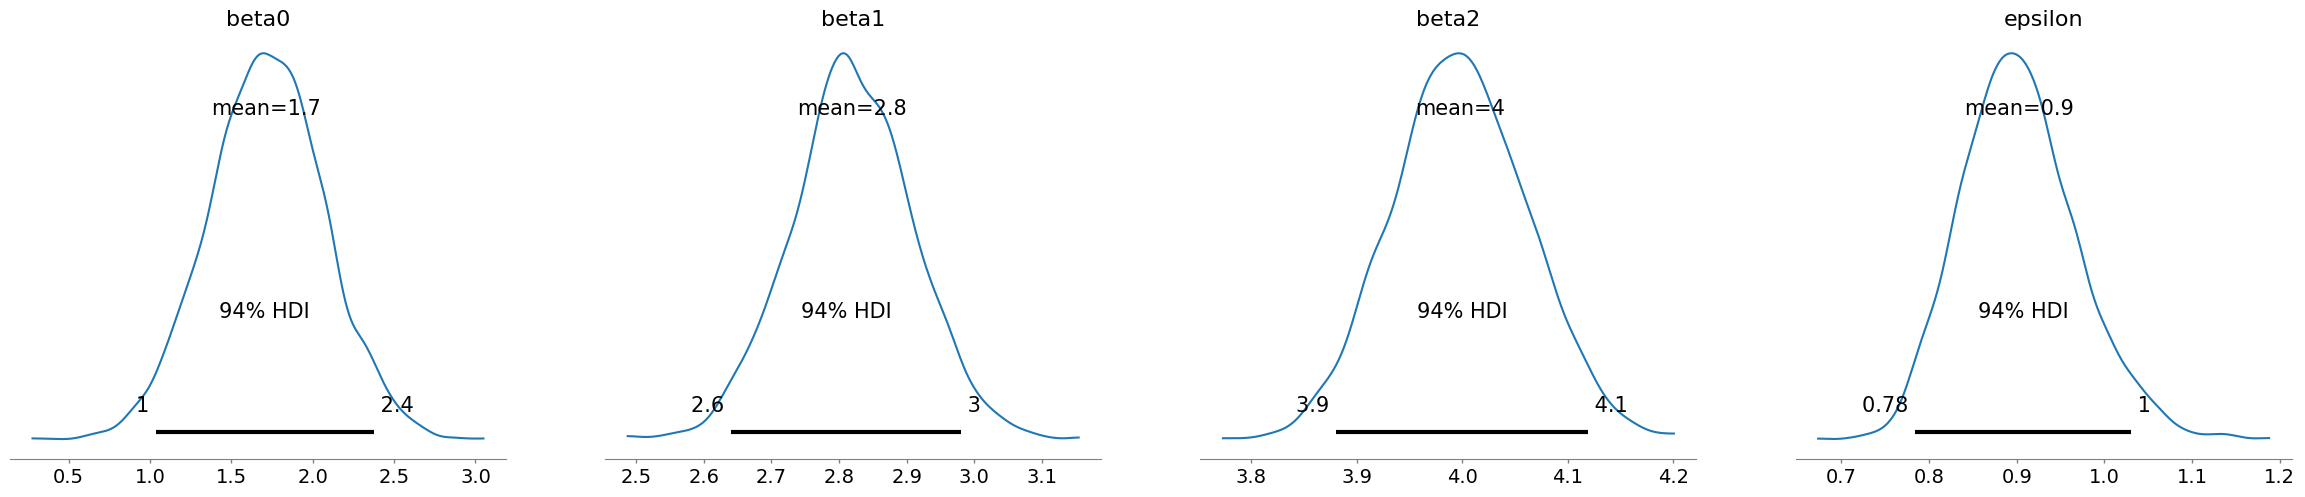

In [7]:
az.plot_posterior(idata)
plt.show()

## 不均一分散の場合

In [8]:
# 不均一分散の場合
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

sigma = 1 + normalize(X[:, 1] + X[:, 2]) * 3
e = np.random.normal(loc=0, scale=sigma, size=n)
y = X @ beta + e

In [9]:
# 頻度主義
import statsmodels.api as sm
ols = sm.OLS(y, X).fit(cov_type="HC1")
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     394.7
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           2.49e-47
Time:                        13:35:25   Log-Likelihood:                -234.90
No. Observations:                 100   AIC:                             475.8
Df Residuals:                      97   BIC:                             483.6
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2521      1.070      0.236      0.814      -1.845       2.349
x1             2.9778      0.313      9.526      0.000       2.365       3.590
x2             4.3672      0.191     22.902      0.000       3.993       4.741
==============================================================================
Omnibus:                       11.057   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.272
Skew:                          -0.749   Prob(JB):                      0.00357
Kurtosis:                       3.678   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

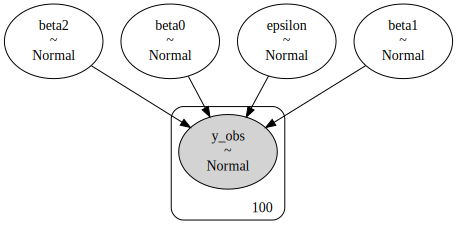

In [10]:
import pymc as pm
import arviz as az

model = pm.Model()
with model:
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    epsilon = pm.Normal("epsilon", mu=0, sigma=1)
    # 平均値 mu
    mu = beta0 + beta1 * X[:, 1] + beta2 * X[:, 2] + epsilon
    # 観測値をもつ確率変数は_obsとする
    y_obs = pm.Normal("y_obs", mu=mu, sigma=epsilon, observed=y)

# モデルをGraphvizで表示
pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, epsilon]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


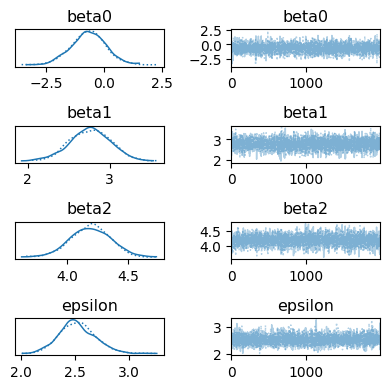

In [11]:
# ベイズ線形回帰モデルをサンプリング
with model:
    idata = pm.sample(
        chains=2,
        tune=1000, # バーンイン期間の、捨てるサンプル数
        draws=2000, # 採用するサンプル数
        random_seed=0,
    )

# 各chainsの結果を表示
az.plot_trace(idata, figsize=[4, 4])
plt.tight_layout()
plt.show()

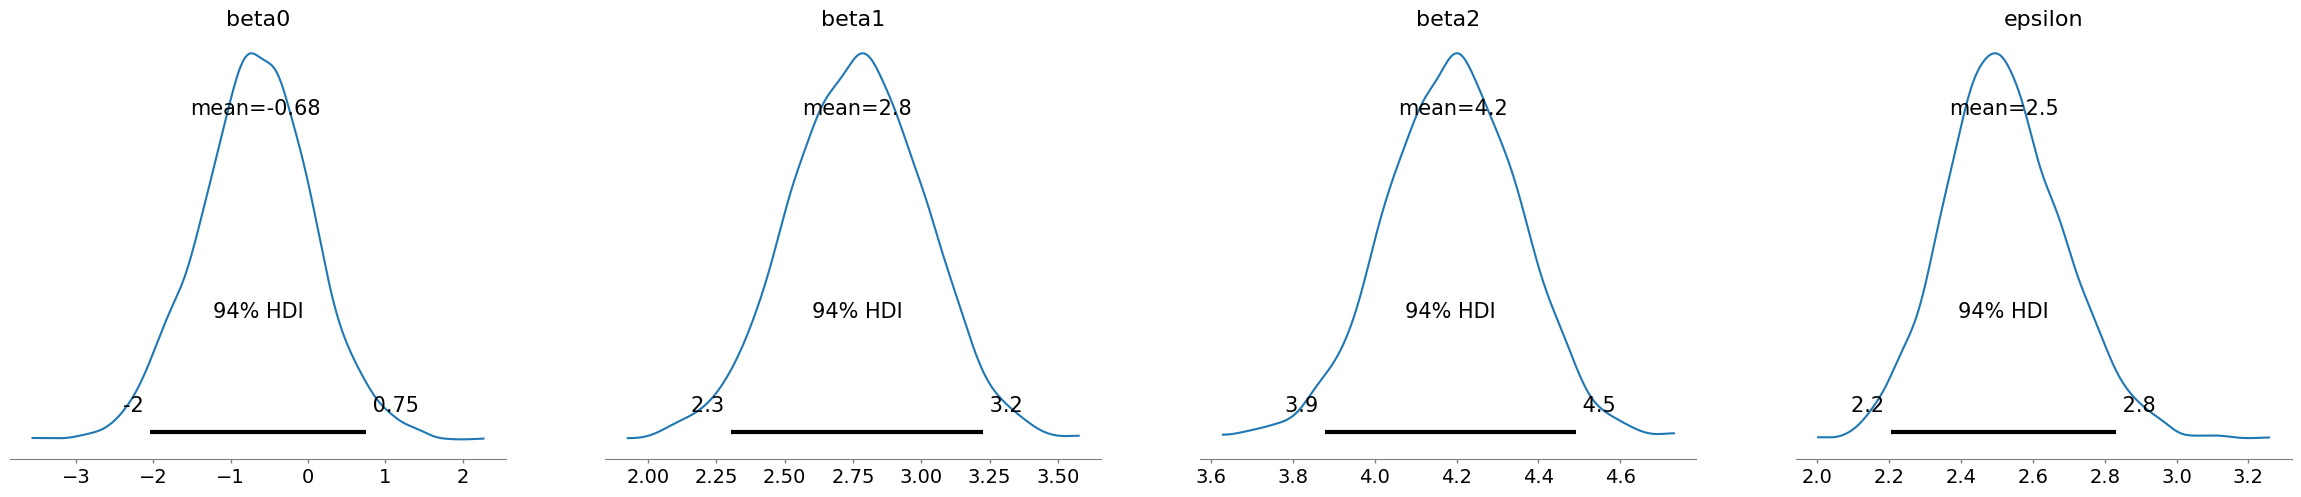

In [12]:
az.plot_posterior(idata)
plt.show()